### Model to reassign all true uniques: set coverage

Model inputs

In [18]:
import numpy as np

A = np.array([[3,1,0],[0,1,2],[1,0,0],[2,0,1],[0,1,0],[2,1,2],[0,3,4]]).T

# define all the input data for the model
I, K = A.shape[0], A.shape[1]
nj = 3
r = 1

V = []
for k in range(K):
    row = []
    for i in range(I):
        if A[i, k] <= r and A[i, k] > 0:
            row.append(i)
    V.append(row)
print(V)

W = np.empty([I, I, K])
for i in range(I):
    for j in range(I):
        for k in range(K):
            if A[i, k] == 0 or A[j, k] == 0:
                W[i, j, k] = 50
            else:
                W[i, j, k] = 1 / A[i, k] + 1 / A[j, k]
print(W.shape, W[:, :, 5])            

[[1], [1], [0], [2], [1], [1], []]
(3, 3, 7) [[1.  1.5 1. ]
 [1.5 2.  1.5]
 [1.  1.5 1. ]]


Coverage I: all except the origin and other uniques

In [17]:
import numpy as np

## define coverage aijk
T = np.ones((I, I, K))

for i in range(I): 
    for j in range(I):
        for k in range(K):
            if i == j or j in V[k]:
                T[i, j, k] = 0
T[:, :, 5]

array([[0., 0., 1.],
       [1., 0., 1.],
       [1., 0., 0.]])

Run model

In [7]:
import pandas as pd
from gurobipy import Model, GRB, LinExpr, quicksum

# initialize model
m = Model('td')
# m.Params.LogToConsole = 0

# add objective function
obj = LinExpr()

# add decision variables and objective function
theta = {}
for k in range(K):
    if len(V[k]) == 0:
        continue
    for i in V[k]:
        for j in range(I):
            # decision variables
            theta[i, j, k] = m.addVar(vtype=GRB.CONTINUOUS, lb=0, ub=1, name="theta_%d_%d_%d"%(i, j, k))
            # m.update()
            # objective
            obj += theta[i, j, k] * A[i, k] * W[i, j, k]

        # add constraints
        m.addConstr(quicksum(theta[i, j, k] for j in range(I)) == 1)
        m.addConstr(quicksum(T[i, j, k] * theta[i, j, k] for j in range(I)) == 1)

for j in range(I):
    m.addConstr(quicksum(quicksum(theta[i, j, k] * A[i, k] for i in V[k]) for k in range(K)) <= nj)

m.setObjective(obj, GRB.MINIMIZE)

m.update()
m.optimize()


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2022-08-05
Using license file C:\Users\10716\gurobi.lic
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 15 rows, 18 columns and 48 nonzeros
Model fingerprint: 0xc3050b0f
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 13 rows and 14 columns
Presolve time: 0.02s
Presolved: 2 rows, 4 columns, 7 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0583333e+02   1.000000e+00   0.000000e+00      0s
       1    1.0583333e+02   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  1.058333333e+02


In [19]:
for var in m.getVars():
    print(var.VarName, var.X)

theta_1_0_0 1.0
theta_1_1_0 0.0
theta_1_2_0 0.0
theta_1_0_1 0.0
theta_1_1_1 0.0
theta_1_2_1 1.0
theta_0_0_2 0.0
theta_0_1_2 1.0
theta_0_2_2 0.0
theta_2_0_3 1.0
theta_2_1_3 0.0
theta_2_2_3 0.0
theta_1_0_4 0.0
theta_1_1_4 0.0
theta_1_2_4 1.0
theta_1_0_5 1.0
theta_1_1_5 0.0
theta_1_2_5 0.0


Disclosure risks after protection: VOTINGAGE (2) $*$ HISPANIC (2) $*$ RACE (7)

In [14]:
theta_all = np.zeros([I, I, K])
for k in range(K):
    for i in range(I):
        if i not in V[k] and A[i, k] != 0:
            theta_all[i, i, k] = 1

for var in m.getVars():
    name = var.VarName.split("_")
    theta_all[int(name[1]), int(name[2]), int(name[3])] = var.X

# check
print(theta_all[:,:,0])
print(theta_all[:,:,5])

[[1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]]
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [105]:
p = np.ones([I, K])
for k in range(K):
    for j in range(I):
        sum = 0
        for i in V[k]:
            if i != j:
                sum += theta_all[i, j, k] * A[i, k]
        p[j, k] = theta_all[j, j, k] / (theta_all[j, j, k] * A[j, k] + sum)

p[~np.isfinite(p)] = 0
print("Identification prob: ", np.sum(p) / p.size)

c:\Users\10716\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


Identification prob:  0.03446742608945718


In [106]:
v = 0
for k in range(K):
    for i in range(I):
        if A[i, k] == 1 and theta_all[i, i, k] == 1:
            v += 1

print("Unique prob: ", np.sum(v) / (I * K))

Unique prob:  0.0


Disclosure risks after protection: HISPANIC (2) $*$ RACE (7)

In [107]:
K2 = hist2.shape[1] - 1
Q2 = np.empty([K2, K])

for idx2, col2 in enumerate(hist2.iloc[:,1:].columns):
    x = col2[0:2]
    y = col2[2:4]
    for idx, col in enumerate(hist.iloc[:,1:].columns):
        if x == col[0:2] and y == col[4:6]:
            Q2[idx2, idx] = 1
        else:
            Q2[idx2, idx] = 0

theta2_all = np.empty([I, I, K2])
for k2 in range(K2):
    for i in range(I):
        for j in range(I):
            sum1, sum2 = 0, 0
            for k in range(K):
                sum1 += Q2[k2, k] * theta_all[i, j, k] * A[i, k]
                sum2 += Q2[k2, k] * A[i, k]
            theta2_all[i, j, k2] = sum1 / sum2
            
theta2_all[~np.isfinite(theta2_all)] = 0
# check
np.sum(theta2_all, axis=1)        

c:\Users\10716\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


array([[1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 0., 1., 0.],
       [1., 1., 1., ..., 0., 1., 0.],
       ...,
       [1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [108]:
p = np.ones([I, K2])
for k2 in range(K2):
    for j in range(I):
        sum = 0
        for k in range(K):
            sum += Q2[k2, k] * theta_all[j, j, k] * A[j, k] 
            for i in V[k]:
                if i != j:
                    sum += Q2[k2, k] * theta_all[i, j, k] * A[i, k]
        p[j, k2] = theta2_all[j, j, k2] / sum
p[~np.isfinite(p)] = 0
print("Identification prob: ", np.sum(p) / p.size)

c:\Users\10716\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


Identification prob:  0.028175008300853396


In [109]:
v = 0
A2 = hist2.iloc[:,1:].to_numpy()
for k2 in range(K2):
    for i in range(I):
        if A2[i, k2] == 1 and theta2_all[i, i, k2] == 1:
            v += 1

print("Unique prob: ", np.sum(v) / (I * K2))

Unique prob:  0.0


Disclosure risks after protection: RACE (7)

In [110]:
K3 = hist3.shape[1] - 1
Q3 = np.empty([K3, K])

for idx3, col3 in enumerate(hist3.iloc[:,1:].columns):
    x = col3[0:2]
    for idx, col in enumerate(hist.iloc[:,1:].columns):
        if x == col[0:2]:
            Q3[idx3, idx] = 1
        else:
            Q3[idx3, idx] = 0

theta3_all = np.empty([I, I, K3])
for k3 in range(K3):
    for i in range(I):
        for j in range(I):
            sum1, sum2 = 0, 0
            for k in range(K):
                sum1 += Q3[k3, k] * theta_all[i, j, k] * A[i, k]
                sum2 += Q3[k3, k] * A[i, k]
            theta3_all[i, j, k3] = sum1 / sum2
            
theta3_all[~np.isfinite(theta3_all)] = 0
# check
np.sum(theta3_all, axis=1)        

c:\Users\10716\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


array([[1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 0., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [111]:
p = np.ones([I, K3])
for k3 in range(K3):
    for j in range(I):
        sum = 0
        for k in range(K):
            sum += Q3[k3, k] * theta_all[j, j, k] * A[j, k] 
            for i in V[k]:
                if i != j:
                    sum += Q3[k3, k] * theta_all[i, j, k] * A[i, k]
        p[j, k3] = theta3_all[j, j, k3] / sum
p[~np.isfinite(p)] = 0
print("Identification prob: ", np.sum(p) / p.size)

c:\Users\10716\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


Identification prob:  0.024519269867160496


In [112]:
v = 0
A3 = hist3.iloc[:,1:].to_numpy()
for k3 in range(K3):
    for i in range(I):
        if A3[i, k3] == 1 and theta3_all[i, i, k3] == 1:
            v += 1

print("Unique prob: ", np.sum(v) / (I * K3))

Unique prob:  0.0


SMAPE and penalized MAPE

In [113]:
# VOTINGAGE (2) $*$ HISPANIC (2) $*$ RACE (7)
delta = np.empty([I, K])
delta_p = np.empty([I, I, K])
for k in range(K):
    for j in range(I):
        sum = 0
        for i in V[k]:
            delta_p[i, j, k] = theta_all[i, j, k] * A[i, k] * W[i, j, k]
            if i != j:
                sum += theta_all[i, j, k] * A[i, k]
        new = theta_all[j, j, k] * A[j, k] + sum
        delta[j, k] = abs(A[j, k] - new) / (A[j, k] + new)

delta[~np.isfinite(delta)] = 0
delta_p[~np.isfinite(delta_p)] = 0
print("SMAPE: ", np.sum(delta) / (I * K))
print("P-MAPE: ", np.sum(delta_p) / (I * K))

c:\Users\10716\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


SMAPE:  0.23328700586173698
P-MAPE:  4.033453614740033


In [114]:
# HISPANIC (2) $*$ RACE (7)
delta2 = np.empty([I, K2])
for k2 in range(K2):
    for j in range(I):
        new = 0
        for i in range(I):
            new += theta2_all[i, j, k2] * A2[i, k2]
        delta2[j, k2] = abs(A2[j, k2] - new) / (A2[j, k2] + new)

delta2[~np.isfinite(delta2)] = 0
print("SMAPE: ", np.sum(delta2) / (I * K2))

c:\Users\10716\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


SMAPE:  0.2540773411495699


In [115]:
# RACE (7)
delta3 = np.empty([I, K3])
for k3 in range(K3):
    for j in range(I):
        new = 0
        for i in range(I):
            new += theta3_all[i, j, k3] * A3[i, k3]
        delta3[j, k3] = abs(A3[j, k3] - new) / (A3[j, k3] + new)

delta3[~np.isfinite(delta3)] = 0
print("SMAPE: ", np.sum(delta3) / (I * K3))

c:\Users\10716\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


SMAPE:  0.15372884166584785


LISA:FA

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


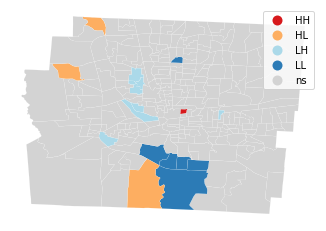

In [155]:
import numpy as np
import geopandas as gpd
from pysal.lib import weights
from pysal.explore import esda
import matplotlib.pyplot as plt  # Graphics
from splot.esda import lisa_cluster

np.random.seed(0)
filename_gdf = 'data/franklin_tract10.json'
gdf = gpd.read_file(filename_gdf)
merged_fa = gdf.set_index('GEOID10').join(hist2.set_index('TRACT'))
merged_fa["0101_pct_before"] = merged_fa["0200"]/(merged_fa["0000"]+merged_fa["0100"]+merged_fa["0200"]+merged_fa["0300"]+merged_fa["0400"]+merged_fa["0500"]+merged_fa["0600"]+merged_fa["0001"]+merged_fa["0101"]+merged_fa["0201"]+merged_fa["0301"]+merged_fa["0401"]+merged_fa["0501"]+merged_fa["0601"]) * 100
merged_fa = merged_fa.sort_index()

gdf['GEOID10'] = gdf['GEOID10'].astype(str)
w = weights.distance.KNN.from_dataframe(gdf, k=20)
w.transform = 'R'
lisa = esda.moran.Moran_Local(merged_fa["0101_pct_before"], w)
fig = lisa_cluster(lisa, gdf)
plt.savefig('plot/lisa_original.eps', format='eps')

c:\Users\10716\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


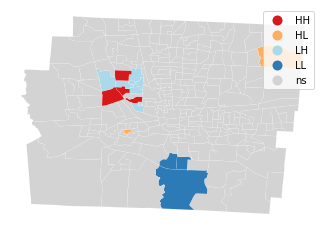

In [156]:
## FA
import csv
import numpy as np
import geopandas as gpd
from splot.esda import lisa_cluster

with open('data/theta/SCM-FA.csv', newline='') as f:
    reader = csv.reader(f)
    data_fa = list(reader)

theta_fa = np.empty([I, I, K])
for k in range(K):
    for i in range(I):
        if i not in V[k] and A[i, k] != 0:
            theta_fa[i, i, k] = 1
for var in data_fa:
    name = var[0].split("_")
    theta_fa[int(name[1]), int(name[2]), int(name[3])] = var[1]

K2 = hist2.shape[1] - 1
Q2 = np.empty([K2, K])
for idx2, col2 in enumerate(hist2.iloc[:,1:].columns):
    x = col2[0:2]
    y = col2[2:4]
    for idx, col in enumerate(hist.iloc[:,1:].columns):
        if x == col[0:2] and y == col[4:6]:
            Q2[idx2, idx] = 1
        else:
            Q2[idx2, idx] = 0
theta2_fa = np.empty([I, I, K2])
for k2 in range(K2):
    for i in range(I):
        for j in range(I):
            sum1, sum2 = 0, 0
            for k in range(K):
                sum1 += Q2[k2, k] * theta_fa[i, j, k] * A[i, k]
                sum2 += Q2[k2, k] * A[i, k]
            theta2_fa[i, j, k2] = sum1 / sum2           
theta2_fa[~np.isfinite(theta2_fa)] = 0

A2 = hist2.iloc[:,1:].to_numpy()
A2_fa = np.empty([I, K2])
for k2 in range(K2):
    for j in range(I):
        sum = 0
        for i in range(I):
            sum += theta2_fa[i, j, k2] * A2[i, k2]
        A2_fa[j, k2] = sum

A2_fa = pd.DataFrame(A2_fa)
A2_fa["TRACT"] = hist2["TRACT"]
merged_fa = merged_fa.join(A2_fa.set_index('TRACT'))
merged_fa["0101_pct_after"] = merged_fa[2]/(merged_fa[0]+merged_fa[1]+merged_fa[2]+merged_fa[3]+merged_fa[4]+merged_fa[5]+merged_fa[6]+merged_fa[7]+merged_fa[8]+merged_fa[9]+merged_fa[10]+merged_fa[11]+merged_fa[12]+merged_fa[13]) * 100
merged_fa['0101_pct_after'] = merged_fa['0101_pct_after'].fillna(0)
merged_fa = merged_fa.sort_index()

gdf['GEOID10'] = gdf['GEOID10'].astype(str)
w = weights.distance.KNN.from_dataframe(gdf, k=20)
w.transform = 'R'
lisa_fa = esda.moran.Moran_Local(merged_fa["0101_pct_after"], w)
fig = lisa_cluster(lisa_fa, gdf)
plt.savefig('plot/lisa_scm_fa.eps', format='eps')

LISA: SP

In [157]:
import numpy as np
import geopandas as gpd
from pysal.lib import weights
from pysal.explore import esda
import matplotlib.pyplot as plt  # Graphics
from splot.esda import lisa_cluster

filename_gdf = 'data/franklin_tract10.json'
gdf = gpd.read_file(filename_gdf)
merged_sp = gdf.set_index('GEOID10').join(hist2.set_index('TRACT'))
merged_sp["0101_pct_before"] = merged_sp["0200"]/(merged_sp["0000"]+merged_sp["0100"]+merged_sp["0200"]+merged_sp["0300"]+merged_sp["0400"]+merged_sp["0500"]+merged_sp["0600"]+merged_sp["0001"]+merged_sp["0101"]+merged_sp["0201"]+merged_sp["0301"]+merged_sp["0401"]+merged_sp["0501"]+merged_sp["0601"]) * 100
merged_sp = merged_sp.sort_index()

gdf['GEOID10'] = gdf['GEOID10'].astype(str)
w = weights.distance.KNN.from_dataframe(gdf, k=20)
w.transform = 'R'
lisa = esda.moran.Moran_Local(merged_sp["0101_pct_before"], w)

c:\Users\10716\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


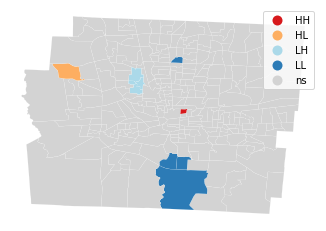

In [158]:
## SP
import csv
import numpy as np
import geopandas as gpd
from splot.esda import lisa_cluster

with open('data/theta/SCM-SP.csv', newline='') as f:
    reader = csv.reader(f)
    data_sp = list(reader)

theta_sp = np.empty([I, I, K])
for k in range(K):
    for i in range(I):
        if i not in V[k] and A[i, k] != 0:
            theta_sp[i, i, k] = 1
for var in data_sp:
    name = var[0].split("_")
    theta_sp[int(name[1]), int(name[2]), int(name[3])] = var[1]

K2 = hist2.shape[1] - 1
Q2 = np.empty([K2, K])
for idx2, col2 in enumerate(hist2.iloc[:,1:].columns):
    x = col2[0:2]
    y = col2[2:4]
    for idx, col in enumerate(hist.iloc[:,1:].columns):
        if x == col[0:2] and y == col[4:6]:
            Q2[idx2, idx] = 1
        else:
            Q2[idx2, idx] = 0
theta2_sp = np.empty([I, I, K2])
for k2 in range(K2):
    for i in range(I):
        for j in range(I):
            sum1, sum2 = 0, 0
            for k in range(K):
                sum1 += Q2[k2, k] * theta_sp[i, j, k] * A[i, k]
                sum2 += Q2[k2, k] * A[i, k]
            theta2_sp[i, j, k2] = sum1 / sum2           
theta2_sp[~np.isfinite(theta2_sp)] = 0

A2 = hist2.iloc[:,1:].to_numpy()
A2_sp = np.empty([I, K2])
for k2 in range(K2):
    for j in range(I):
        sum = 0
        for i in range(I):
            sum += theta2_sp[i, j, k2] * A2[i, k2]
        A2_sp[j, k2] = sum

A2_sp = pd.DataFrame(A2_sp)
A2_sp["TRACT"] = hist2["TRACT"]
merged_sp = merged_sp.join(A2_sp.set_index('TRACT'))
merged_sp["0101_pct_after"] = merged_sp[2]/(merged_sp[0]+merged_sp[1]+merged_sp[2]+merged_sp[3]+merged_sp[4]+merged_sp[5]+merged_sp[6]+merged_sp[7]+merged_sp[8]+merged_sp[9]+merged_sp[10]+merged_sp[11]+merged_sp[12]+merged_sp[13]) * 100
merged_sp['0101_pct_after'] = merged_sp['0101_pct_after'].fillna(0)
merged_sp = merged_sp.sort_index()

gdf['GEOID10'] = gdf['GEOID10'].astype(str)
w = weights.distance.KNN.from_dataframe(gdf, k=20)
w.transform = 'R'
lisa_sp = esda.moran.Moran_Local(merged_sp["0101_pct_after"], w)
fig = lisa_cluster(lisa_sp, gdf)
plt.savefig('plot/lisa_scm_sp.eps', format='eps')

Confusion matrix

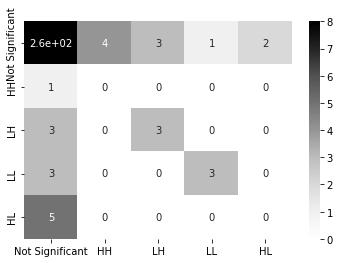

In [164]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

ls = [lisa.q[i] if lisa.p_sim[i] <= 0.05 else 0 for i in range(len(lisa.q))]
ls_fa = [lisa_fa.q[i] if lisa_fa.p_sim[i] <= 0.05 else 0 for i in range(len(lisa_fa.q))]

cf_fa = confusion_matrix(ls, ls_fa)
ax = sns.heatmap(cf_fa, annot=True, cmap='Greys', vmin=0, vmax=8)
ax.xaxis.set_ticklabels(['Not Significant','HH','LH','LL','HL'])
ax.yaxis.set_ticklabels(['Not Significant','HH','LH','LL','HL'])
plt.savefig('plot/lisa_scm_fa_hist.eps', format='eps')

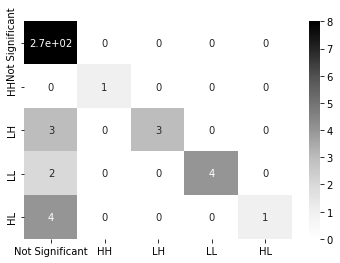

In [165]:
ls_sp = [lisa_sp.q[i] if lisa_sp.p_sim[i] <= 0.05 else 0 for i in range(len(lisa_sp.q))]

cf_sp = confusion_matrix(ls, ls_sp)
ax = sns.heatmap(cf_sp, annot=True, cmap='Greys', vmin=0, vmax=8)
ax.xaxis.set_ticklabels(['Not Significant','HH','LH','LL','HL'])
ax.yaxis.set_ticklabels(['Not Significant','HH','LH','LL','HL'])
plt.savefig('plot/lisa_scm_sp_hist.eps', format='eps')